# Reads Assignment

In [29]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from starmap.sequencing import *
from natsort import natsorted
from scipy.io import loadmat, savemat

## Input

In [30]:
# IO path 
base_path = 'Z:/Data/Analyzed/2021-09-07-Hu-TissueRIBOmap-Fix/'
# base_path = 'Z:/Data/Analyzed/2021-09-07-Hu-TissueSTARmap-Fix/'
out_path = os.path.join(base_path, 'output')
if not os.path.exists(out_path):
    os.mkdir(out_path)

### Functions

In [31]:
from functools import wraps
from time import time

# Timer
def timer(func):
    @wraps(func)
    def _time_it(*args, **kwargs):
        start = int(round(time() * 1000))
        try:
            return func(*args, **kwargs)
        finally:
            end_ = int(round(time() * 1000)) - start
            end_ = round(end_ / 1000, 4)
            print(f"Total execution time: {end_ if end_ > 0 else 0} s")
    return _time_it


# Trim reads 
@timer
def load_reads(input_path, save_as=True):

    current_dots = loadmat(os.path.join(input_path, 'merged_goodPoints_max3d.mat'))
    # Get reads
    bases = [i[0] for i in current_dots["merged_num"]]
    bases = np.array(bases)
    # Get reads location
    temp = current_dots["merged_points"]

    # Convert to 0 indexed and switch axis for python
    temp = temp[:, :2]
    points = np.zeros(temp.shape)
    points[:, 0] = temp[:, 1]-1
    points[:, 1] = temp[:, 0]-1
    
    points[:, 0] = np.round(points[:, 0] * .3)
    points[:, 1] = np.round(points[:, 1] * .3)
    
    print(f"Number of reads: {len(bases)}")
    
    return points, bases


# Load genes.csv
def load_genes(base_path):
    genes2nums = {}
    nums2genes = {}
    with open(os.path.join(base_path, "genes.csv"), encoding='utf-8-sig') as f:
        for i,l in enumerate(f):
            fields = l.rstrip().split(",")
            # print("".join([str(s+1) for s in encode_SOLID(fields[1][::-1])]))
            # curr_seg = "".join([str(s+1) for s in encode_SOLID(fields[1][::-1])])
            genes2nums[fields[0]] = i+1
            nums2genes[genes2nums[fields[0]]] = fields[0]
            
    return genes2nums, nums2genes

## Run pipeline for individual sample

In [32]:
# Load reads 
points, bases = load_reads(base_path)

# Load genes
genes2nums, nums2genes = load_genes(base_path)

Number of reads: 9422992
Total execution time: 6.331 s


## Load segmentation

In [33]:
cell_raw = load_label_image(os.path.join(base_path, 'images'), fname='overlay_scaled_03.tif')
cell_seg = load_label_image(os.path.join(base_path, 'segmentation'), fname='cell_seg_scaled_03.tiff')

fig_out_path = os.path.join(base_path, 'figures')
if not os.path.exists(fig_out_path):
    os.mkdir(fig_out_path)

In [58]:
# Plot cell number 
t_size = 5
plt.figure(figsize=(100, 120))
plt.imshow(cell_raw)
for i, region in enumerate(regionprops(cell_seg)):
    plt.plot(region.centroid[1], region.centroid[0], '.', color='red', markersize=1)
    plt.text(region.centroid[1], region.centroid[0], str(i), fontsize=t_size, color='red')

plt.axis('off')
plt.savefig(os.path.join(fig_out_path, "cell_nums.png"), bbox_inches='tight', dpi=200)
plt.clf()
plt.close()

In [59]:
# Plot dots on segmentation mask
plt.figure(figsize=(100, 120))
plt.imshow(cell_seg > 0, cmap='gray')
plt.plot(points[:, 1], points[:, 0], '.', color='red', markersize=.1)
plt.axis('off')
plt.savefig(os.path.join(fig_out_path, "points_seg.png"), bbox_inches='tight', dpi=200)
plt.clf()
plt.close()

In [60]:
# Plot dots on nissl
plt.figure(figsize=(100, 120))
plt.imshow(cell_raw, cmap='gray')
plt.plot(points[:, 1], points[:, 0], '.', color='red', markersize=.1)
plt.axis('off')
plt.savefig(os.path.join(fig_out_path, "points_raw.png"), bbox_inches='tight', dpi=200)
plt.clf()
plt.close()

## Read assignment

In [61]:
%%time
# Reads assignment to cell (new)
expr_out_path = os.path.join(out_path, 'expr')
if not os.path.exists(expr_out_path):
    os.mkdir(expr_out_path)
        
points = points.astype(int)
reads_assignment = cell_seg[points[:, 0], points[:, 1]]
    
cell_locs = []
total_cells = len(np.unique(cell_seg)) - 1
areas = []

# gene_seqs = seqs2genes.keys()
gene_seqs = nums2genes.keys()
cell_by_barcode = np.zeros((total_cells, len(gene_seqs)))
gene_seq_to_index = {}  # map from sequence to index into matrix

for i, k in enumerate(gene_seqs):
    gene_seq_to_index[k] = i
    
# Iterate through cells
print('Iterate cells...')
for i, region in enumerate(regionprops(cell_seg)):
    # print(region.label)
    areas.append(region.area)
    cell_locs.append(region.centroid)
    
    assigned_reads = bases[np.argwhere(reads_assignment == region.label).flatten()]
    for j in assigned_reads:
        if j in gene_seq_to_index:
            cell_by_barcode[i, gene_seq_to_index[j]] += 1
    
     
# Keep the good cells 
cell_locs = np.array(cell_locs).astype(int)
# cell_by_barcode = cell_by_barcode[good_cells, :] 
curr_meta = pd.DataFrame({'area': areas, 'x':cell_locs[:, 1], 'y':cell_locs[:, 0], 'protocol': 'STARmap'})

with open(os.path.join(expr_out_path, "log.txt"), 'w') as f:
    msg = "{:.2%} percent [{} out of {}] reads were assigned to {} cells".format(cell_by_barcode.sum()/len(bases), cell_by_barcode.sum(), len(bases), total_cells)
    print(msg)
    f.write(msg)
np.savetxt(os.path.join(expr_out_path, "cell_barcode_count.csv"), cell_by_barcode.astype(np.int), delimiter=',', fmt="%d")
cell_barcode_names = pd.DataFrame({'seq': list(nums2genes.keys()), 'gene': list(nums2genes.values())})
cell_barcode_names.to_csv(os.path.join(expr_out_path, "cell_barcode_names.csv"), header=False)
curr_meta.to_csv(os.path.join(expr_out_path, "meta.csv"))

Iterate cells...
43.36% percent [9126907.0 out of 21048864] reads were assigned to 50858 cells
Wall time: 22min 53s
Parser   : 104 ms


In [62]:
curr_meta.head()

,area,x,y,protocol
0,553,1923,366,RIBOmap
1,741,1953,377,RIBOmap
2,391,1974,377,RIBOmap
3,264,1979,393,RIBOmap
4,454,1988,410,RIBOmap


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

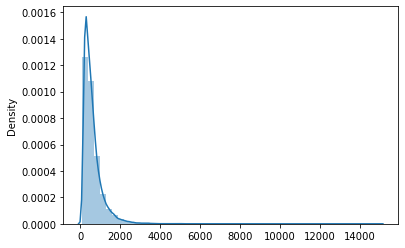

In [63]:
# Plot area distribution
sns.distplot(areas)

## output read info

In [34]:
points = points.astype(int)
reads_assignment = cell_seg[points[:, 0], points[:, 1]]
reads = list(map(lambda x: nums2genes[x], bases))

In [35]:
reads_info = pd.DataFrame({'row': points[:, 0], 'col': points[:, 1], 'cell_label':reads_assignment})
reads_info = reads_info.astype(np.int32)
reads_info['orig_index'] = reads_info['cell_label'] - 1
reads_info['gene'] = reads
reads_info

,row,col,cell_label,orig_index,gene
0,593,680,488,487,Peg3
1,431,904,227,226,Psap
2,434,918,227,226,Psap
3,606,669,488,487,H3f3b
4,601,674,488,487,Klhl6
...,...,...,...,...,...
9422987,13429,2435,47108,47107,Rapgef3
9422988,13505,2430,0,-1,Hnrnpab
9422989,13488,2374,47238,47237,Shisa4
9422990,13351,2984,47048,47047,Ell2


In [36]:
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')

In [37]:
reads_info.to_csv(os.path.join(out_path, f'{date}-reads-info.csv'))

## Check expression pattern

In [64]:
# Get assigned reads 
assigned_index = np.argwhere(reads_assignment != 0).flatten()
assigned_bases = bases[assigned_index]
assigned_points = points[assigned_index, :]

In [79]:
gene = 'Aldoc'
curr_index = np.argwhere(assigned_bases == genes2nums[gene]).flatten()
curr_points = assigned_points[curr_index, :]
print(f"Number of reads: {curr_points.shape[0]}")

Number of reads: 50345


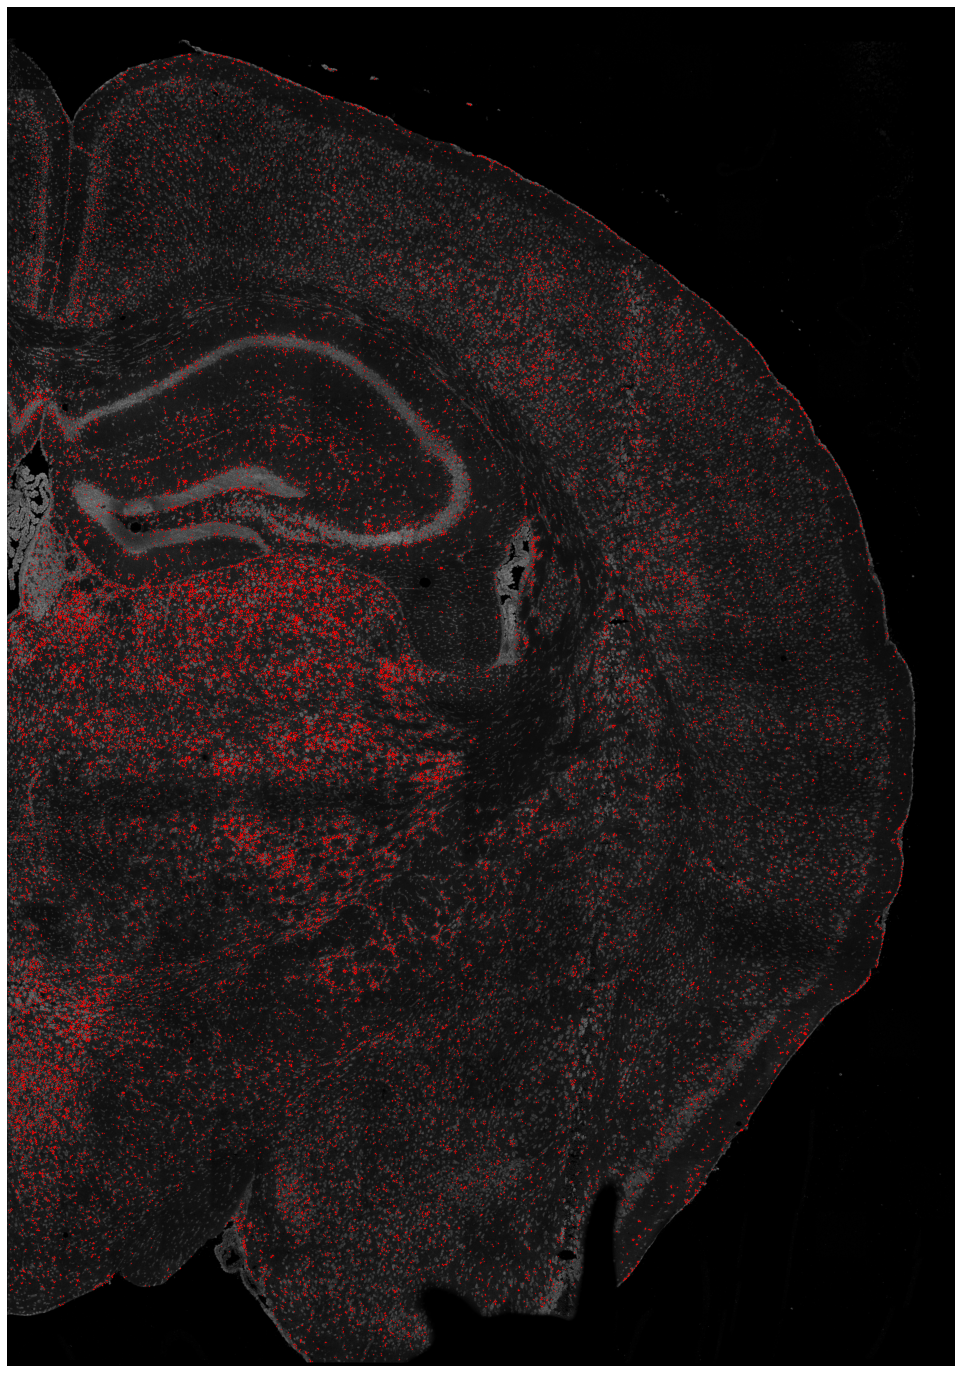

In [80]:
# Plot dots on segmentation mask
plt.figure(figsize=(25, 25))
plt.imshow(cell_raw, cmap='gray')
plt.plot(curr_points[:, 1], curr_points[:, 0], '.', color='red', markersize=.5)
plt.axis('off')
plt.show()

In [67]:
# Get read quantification for each gene after read assignemnt 
per_gene_expr = pd.DataFrame({'gene': list(nums2genes.values()), 'expr': cell_by_barcode.sum(axis=0)})
per_gene_expr = per_gene_expr.sort_values('expr', ascending=False, ignore_index=True)
per_gene_expr.head(20)

,gene,expr
0,Fth1,241015.0
1,Kdr,101157.0
2,Eef1a1,88246.0
3,Calm1,69595.0
4,Calm3,68198.0
5,Tuba1b,62512.0
6,Aldoc,50345.0
7,Cox6c,48473.0
8,Hspa8,41982.0
9,Bcas2,41069.0


In [57]:
# Get top 20 genes & Curated markers 
top20 = per_gene_expr.head(20).gene.to_list()
curated = ['SLC17A7', 'CUX2', 'RORB', 'SULF2', 'PCP4',
          'GAD1', 'PVALB', 'SST', 'NPY', 'VIP', 'MBP', 'MOBP']
selected_genes = top20
selected_genes

['SLC17A7',
 'SLC1A2',
 'SV2B',
 'PLP1',
 'MEF2C',
 'MME',
 'DRD2',
 'CALB1',
 'SLC1A3',
 'RGS4',
 'MAN1A1',
 'SKAP1',
 'NFIX',
 'HOMER3',
 'SLIT3',
 'IGFBP5',
 'CHGA',
 'CNR1',
 'SATB1',
 'PCP4']

In [59]:
expr_figure_out_path = os.path.join(expr_out_path, 'figures')
if not os.path.exists(expr_figure_out_path):
    os.mkdir(expr_figure_out_path)
    
for i, gene in enumerate(selected_genes):
    
    curr_index = np.argwhere(assigned_bases == genes2nums[gene]).flatten()
    curr_points = assigned_points[curr_index, :]
    n_reads = curr_points.shape[0]

    # Plot
    plt.figure(figsize=(20, 80))
    plt.imshow(nissl, cmap='gray')
    plt.plot(curr_points[:, 1], curr_points[:, 0], '.', color='red', markersize=.5)
    plt.axis('off')
    expr_figure_path = os.path.join(expr_figure_out_path, f"{i+1}.{gene}_{n_reads}.png")
    plt.savefig(expr_figure_path)
    plt.clf()
    plt.close()